In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from sklearn import svm
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from methods import *
import pickle, os

In [2]:
%load_ext autoreload
%autoreload 2

clean: 552
polygon: 276
kelvin: 63
gotham: 51
lomo: 60
nashville: 55
toaster: 47

In [69]:
def save_obj(obj, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    if not os.path.isfile(filename):
        print('Pickle {} does not exist.'.format(filename))
        return None
        
    with open(filename, 'rb') as handle:
        obj = pickle.load(handle)
    return obj
def read_features(p_path, trigger_type_aux_str=None):
    report = pd.read_csv(p_path)
    if trigger_type_aux_str is not None:
        indexes = []
        for i in range(len(report)):
            col = report['trigger_type_aux'].iloc[i]
            if col.startswith(trigger_type_aux_str) or col.lower() == 'none':
                indexes.append(i)
        report = report.iloc[indexes]
    initial_columns = report.columns
    col_model_label = report['model_label'].copy(deep=True)
    for c in initial_columns:
        if not c.endswith('mean_diff') and not c.endswith('std_diff'):
            del report[c]
    features = report.values
    labels = np.array([int(col_model_label.iloc[i] == 'backdoor') for i in range(len(report))])
    return abs(features), labels

def evaluate_classifier(train_x, train_y, test_x, test_y):
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(train_x, train_y)
    y_score = clf.predict(test_x)
    y_pred = clf.predict_proba(test_x)
    roc_auc = roc_auc_score(y_true=test_y, y_score=y_score)
    cross_entropy = log_loss(y_true=test_y, y_pred=y_pred)
    return roc_auc, cross_entropy

# Plot trigger-size vs ROC using 5-fold cross validation for Square Data

trigger_type_aux_str = polygon

selecting columns 0 and 1
size=5, index=0: mean_roc=0.6712145262145262, std_roc=0.0381103228547931, mean_xent=0.5102470677673269, std_xent=0.04941408049767729

selecting columns 2 and 3
size=10, index=2: mean_roc=0.7817965367965368, std_roc=0.03777139383101887, mean_xent=0.4140991152371597, std_xent=0.04319532038422369

selecting columns 4 and 5
size=15, index=4: mean_roc=0.8670652958152958, std_roc=0.03610513395421116, mean_xent=0.3027463806524846, std_xent=0.059821810957761436

selecting columns 6 and 7
size=20, index=6: mean_roc=0.8948773448773449, std_roc=0.036753657971420335, mean_xent=0.24530919564599923, std_xent=0.06999369320220325

selecting columns 8 and 9
size=25, index=8: mean_roc=0.899407768157768, std_roc=0.03294727570185857, mean_xent=0.24040654436631823, std_xent=0.11980560046636061

selecting columns 10 and 11
size=30, index=10: mean_roc=0.8948436748436748, std_roc=0.02857267952993193, mean_xent=0.2298260606661501, std_xent=0.02707664551

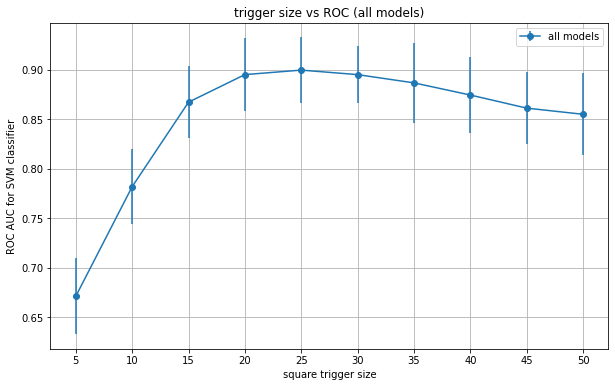

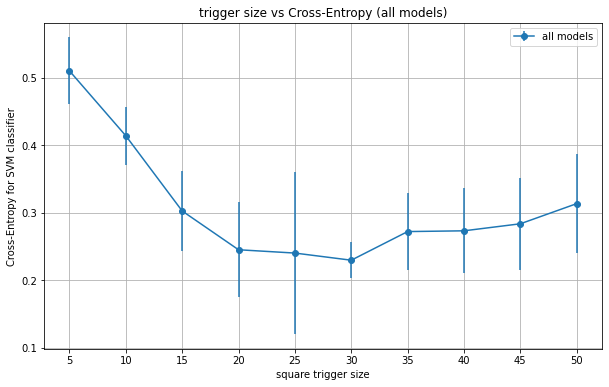

In [55]:
list_square_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
dict_square_sizes = {size:index*2 for index, size in enumerate(list_square_sizes)}
roc_auc_scores, roc_auc_err = [], []
xent_scores, xent_err = [], []
trigger_type_aux_str = 'polygon'
print(f'trigger_type_aux_str = {trigger_type_aux_str}\n')
for size, index in dict_square_sizes.items():
    path = 'confusion-reports/ics_svm/round2-train-dataset/round2-train-dataset_squares.csv'
    X, y = read_features(path, trigger_type_aux_str)
    
    print(f'selecting columns {index} and {index+1}')
    X = X[:, index:index+2]
    
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores_roc, cv_scores_xent = [], []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_index, :], y[train_index] # square_diffs have indexes 0,1 !!!
        X_test, y_test = X[test_index, :], y[test_index] # square_diffs have indexes 0,1 !!!
        roc, xent = evaluate_classifier(X_train, y_train, X_test, y_test)
        cv_scores_roc.append(roc)
        cv_scores_xent.append(xent)
    mean_roc, std_roc = np.mean(cv_scores_roc), np.std(cv_scores_roc)
    mean_xent, std_xent = np.mean(cv_scores_xent), np.std(cv_scores_xent)
    print(f'size={size}, index={index}: mean_roc={mean_roc}, std_roc={std_roc}, mean_xent={mean_xent}, std_xent={std_xent}\n')
    
    roc_auc_scores.append(mean_roc)
    roc_auc_err.append(std_roc)
    xent_scores.append(mean_xent)
    xent_err.append(std_xent)

plt.figure(figsize=(10, 6)).patch.set_color('white')
plt.errorbar(list_square_sizes, roc_auc_scores, roc_auc_err, marker='o', label='all models')
plt.grid()
plt.legend()
plt.xlabel('square trigger size')
plt.ylabel('ROC AUC for SVM classifier')
plt.xticks(list_square_sizes)
plt.title(f'trigger size vs ROC (all models)')
plt.show()

plt.figure(figsize=(10, 6)).patch.set_color('white')
plt.errorbar(list_square_sizes, xent_scores, xent_err, marker='o', label='all models')
plt.grid()
plt.legend()
plt.xlabel('square trigger size')
plt.ylabel('Cross-Entropy for SVM classifier')
plt.xticks(list_square_sizes)
plt.title(f'trigger size vs Cross-Entropy (all models)')
plt.show()

# stratified 5-fold validation for all data (selected square + 5 filters)

In [57]:
path_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square25-filters.csv'
# dict_trigger_indexes = { 'polygon': 0, 'gotham': 2, 'kelvin': 4, 'lomo': 6, 'nashville': 8, 'toaster': 10 }
trigger_type_aux_str = None
print(f'trigger_type_aux_str={trigger_type_aux_str}')
X, y = read_features(path_csv, trigger_type_aux_str) # clean data is automatically added

skf = StratifiedKFold(n_splits=5, shuffle=True)
scores_roc, scores_xent = [], []
for index, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_index, :], y[train_index]
    X_test, y_test = X[test_index, :], y[test_index]
#     print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    roc, xent = evaluate_classifier(X_train, y_train, X_test, y_test)
#     print(f'split #{index}: roc={roc:.4f}, xent={xent:.4f}')
    scores_roc.append(roc)
    scores_xent.append(xent)
print(f'avg roc ={sum(scores_roc) / len(scores_roc)}')
print(f'std roc ={np.std(scores_roc)}')
print()
print(f'avg xent={sum(scores_xent) / len(scores_xent)}')
print(f'std roc ={np.std(scores_xent)}')

trigger_type_aux_str=None
avg roc =0.8849140049140051
std roc =0.017752427945204582

avg xent=0.28982907011774905
std roc =0.02109251709341686


# Plot (mean, std)  of clean data vs (mean, std) of backdoored data (polygon or instagram filter)

In [ ]:
# path_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square20-gotham-kelvin-lomo-nashville-toaster.csv'
# dict_trigger_indexes = { 'polygon': 0, 'gotham': 2, 'kelvin': 4, 'lomo': 6, 'nashville': 8, 'toaster': 10 }
# X_train, y_train = read_features(p_path=path_csv) # clean data is automatically added

# for trigger_type, idx in dict_trigger_indexes.items():
#     print(trigger_type, idx)
#     x_axis = X_train[:, idx]
#     y_axis = X_train[:, idx+1]
    
#     list_labels = [['clean', 'backdoored'][y] for y in y_train]
#     list_colors = [['#1f77b4', 'orange'][y] for y in y_train]
    
#     plt.figure(figsize=(10, 6)).patch.set_color('white')
#     plt.scatter(x_axis, y_axis, c=list_colors, s=20, cmap=plt.cm.Paired)

# #     count_backdoored = 0
# #     count_clean = 0
# #     for label_int, label_name, color in [(0, 'clean', '#1f77b4'), (1, 'backdoored', 'orange')]:
# #         mask = (y_train == label_int)
# #         if label_int == 0:
# #             count_clean = mask.sum()
# #         else:
# #             count_backdoored = mask.sum()
# #         plt.scatter(x_axis[mask], y_axis[mask], c=color, zorder=10, s=20, cmap=plt.cm.Paired, label=label_name)

# #     plt.xlim([0, 20])
# #     plt.ylim([0, 6])
# #     plt.axvline(x=3, ymin=y_axis.min(), ymax=y_axis.max(), color='k')
#     plt.xlabel('mean diff')
#     plt.ylabel('std diff')
#     plt.title(f'({count_clean} clean models) VS ({count_backdoored} {trigger_type}-trigger models)')
#     plt.grid()
# #     plt.legend()
#     plt.show()

# Train meta-model using square data and filters

In [66]:
X_train, y_train = read_features(r'confusion-reports/ics_svm/round2-train-dataset/round2-train-dataset_square25-filters.csv', None)
model = svm.SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
save_obj(model, r'..\metamodels\metamodel_square25_filters_black_square.pickle')

In [72]:
loaded_model = load_obj(r'..\metamodels\metamodel_square25_filters_black_square.pickle')
loaded_model.coef_

array([[ 0.86076052,  0.64287563,  0.21829689, -1.54162633,  0.57326189,
        -1.02720193,  0.69813127, -0.75133954,  0.14650644,  0.06089214,
        -0.01371819, -0.2104749 ]])

# merge or simplify datasets

In [49]:
def select_columns_from_dataset():
    df = pd.read_csv(r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square20-gotham-kelvin-lomo-nashville-toaster.csv')
    for col_to_delete in ['square_mean_diff', 'square_std_diff', 'square_mean', 'square_std']:
        del df[col_to_delete]
    df.to_csv(r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_filters.csv', index=False)
    print('done')

def merge_datasets():
    df1 = pd.read_csv(r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_filters.csv')
    df2 = pd.read_csv(r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_squares.csv')
    for col in ['square25_mean_diff', 'square25_std_diff', 'square25_mean', 'square25_std']:
        df1[col] = df2[col]
    
#     series_data = []
#     for i in range(len(df1)):
#         trigger_type = df1.iloc[i]['trigger_type']
#         trigger_type_option = df1.iloc[i]['trigger_type_option']
#         if trigger_type == 'instagram':
#             series_data.append(trigger_type_option.replace('XForm', '').replace('Filter', ''))
#         else:
#             if trigger_type == 'None':
#                 series_data.append(trigger_type)
#             else:
#                 series_data.append(f'{trigger_type}-{trigger_type_option}')
#     df1['trigger_type_aux'] = series_data
    
    new_order_for_columns = [
        'model_name', 'model_architecture', 'model_label',
        'trigger_type_aux', # 'trigger_type', 'trigger_type_option',

        'square25_mean_diff', 'square25_std_diff',
        'gotham_mean_diff', 'gotham_std_diff',
        'kelvin_mean_diff', 'kelvin_std_diff',
        'lomo_mean_diff', 'lomo_std_diff',
        'nashville_mean_diff', 'nashville_std_diff',
        'toaster_mean_diff', 'toaster_std_diff',

        'clean_mean', 'clean_std',
        'square25_mean', 'square25_std',
        'gotham_mean', 'gotham_std',
        'kelvin_mean', 'kelvin_std',
        'lomo_mean', 'lomo_std',
        'nashville_mean', 'nashville_std',
        'toaster_mean', 'toaster_std',

        'trigger_color', 'num_classes',
    ]
    df1 = df1[new_order_for_columns]
    df1.to_csv(r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square25-filters.csv', index=False)
    print('done')
merge_datasets()
# select_columns_from_dataset()

done
